<a href="https://colab.research.google.com/github/mzisyraf/CS371-Introduction-to-Deep-Learning/blob/main/CS371_assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS371 Assignment #3: Image Segmentation using Fully Convolutional Network (FCN)
---
TA : Jaehoon Yoo (wogns98@kaist.ac.kr)

---
## Instructions
- In this assignment, we will perform semantic segmentation on PASCAL VOC 2011 dataset which contains 20 object categories. We use the Semantic Boundaries Dataset(SBD) as it contains more segmentation labels than the original dataset.
- To this end, you need to implement necessary network components, load and fine-tune the pretrained network, and report segmentation performance on the validation set.
- Fill in the section marked **Px.x** with the appropriate code. **You can only modify inside those areas, and not the skeleton code.**
- To begin, you should download this ipynb file into your own Google drive clicking `make a copy(사본만들기)`. Find the copy in your drive, change their name to `assignment3.ipynb`, if their names were changed to e.g. `Copy of assignment3.ipynb` or `assignment3.ipynb의 사본`.
- Also, you have to download a pretrained VGG network [here](https://drive.google.com/file/d/1QamwWitB7ZkTUbJf10_mcECjvvoBNfin/view?usp=share_link). Upload it to your drive, place it in the same directory with your Colab notebook.
- <font color="red">You'll be training large models. We recommend you to create at least **6GB** of space available on your Google drive to run everything properly.</font>
- Tensorboard may have some issues with the Chrome browser. **Please use Firefox.**
  - https://github.com/googlecolab/colabtools/issues/3990

## Deliverables: <font color="red">**Read carefully**</font>
<font color="red">You will get the full credit **only if** you adhere to the following deliverables.</font>
- <font color="red">Rename the two trained models as `FCN8.pt` and `FCN32.pt`. Upload them to your Google drive, create a **public sharing** link, and attach the link at the bottom of this notebook.</font>
- Download your Colab notebook, submit to KLMS as a single file named **[StudentID].ipynb**

## Submission guidelines
- Your code and report will be this Colab notebook.
- You may run this code on a local machine. However, we should be able to reproduce your results **on Colab**. Submissions failing to run on Colab will get a substantial penalty.
- Your assignment should be submitted through KLMS. All other submissions (e.g., via email) will not be considered as valid submissions.

## Due date
- **23:59:59 November 3rd.**
- Late submission is allowed until 23:59:59 November 5th, with 20% penalty.
- **The last modified date of your model file should also be before the due date.**

## Quiz date
- We will have a quiz on November 6th (Mon).

## Questions
- Please use QnA board in KLMS as the main communication channel. When you post questions, please make it public so that all students can share the information. Please use the prefix "[Assignment 3]" in the subject for all questions regarding this assignment (e.g., [Assignment 3] Regarding the grading policy).

---
# Prerequisite: Mount your gdrive.

In [ ]:
# mount drive https://datascience.stackexchange.com/questions/29480/uploading-images-folder-from-my-system-into-google-colab
# login with your google account and type authorization code to mount on your google drive.
import os
from google.colab import drive
drive.mount('/gdrive')

---
# Prerequisite: Setup the `root` directory properly.

In [ ]:
# Specify the directory path where `assignemnt3.ipynb` exists.
# For example, if you saved `assignment3.ipynb` in `/gdrive/MyDrive/CS371/assignment3` directory,
# then set root = '/gdrive/MyDrive/CS371/assignment3'
root = '/gdrive/MyDrive/CS371/assignment3'

---
# Basic settings

## Import libraries

In [ ]:
import os
import numpy as np
import time
from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation, SBDataset
from torchvision.datasets.vision import StandardTransform
from torchvision.utils import make_grid
from torchvision import transforms
from torchvision.models.vgg import VGG, vgg16, make_layers
from torch.optim import SGD
from torch.utils.tensorboard import SummaryWriter

torch.backends.cudnn.benchmark = True

!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils

## Hyperparameters

In [ ]:
# Basic settings
from easydict import EasyDict as edict

cfg = {'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']}

torch.manual_seed(470)
torch.cuda.manual_seed(470)

args = edict()
args.batch_size = 1
args.lr = 1e-4
args.momentum = 0.9
args.weight_decay = 5e-4
args.epoch = 10
args.tensorboard = True
args.gpu = True

device = 'cuda' if torch.cuda.is_available() and args.gpu else 'cpu'

# Create directory name.
result_dir = Path(root) / 'results'
result_dir.mkdir(parents=True, exist_ok=True)

## Tensorboard

In [ ]:
# Setup tensorboard.
# You may get Error 403 with the Chrome browser. (https://github.com/googlecolab/colabtools/issues/3990)
# Please use Firefox to solve the issue.

if args.tensorboard:
    %load_ext tensorboard
    %tensorboard --logdir "/gdrive/MyDrive/{str(result_dir).replace('/gdrive/MyDrive/', '')}" --samples_per_plugin images=100
else:
    writer = None

---
# Utility functions

Here are some utility functions that we will use throughout this assignment. You don't have to modify any of these.  
**Conditional Random Field (CRF)** is a technique to further improve segmentation performance, mainly focusing on better localization. Details can be found in the [DeepLab](https://arxiv.org/abs/1606.00915) paper.

In [ ]:
# Extracts bias and non-bias parameters from a model.
def get_parameters(model, bias=False):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            if bias:
                yield m.bias
            else:
                yield m.weight
        elif isinstance(m, nn.ConvTranspose2d):
            # weight is frozen because it is just a bilinear upsampling
            if bias:
                assert m.bias is None


# from https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/surgery.py
def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()


# Convert to Long Tensor from Byte Tensor
class toLongTensor:
    def __call__(self, img):
        output = torch.from_numpy(np.array(img).astype(np.int32)).long()
        output[output == 255] = 21
        return output


def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist

def label_accuracy_score(label_trues, label_preds, n_class):
    """ Returns overall accuracy and mean IoU """
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        iou = np.diag(hist) / (
            hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)
        )
    mean_iou = np.nanmean(iou)
    return acc, mean_iou


class Colorize(object):
    """ Colorize the segmentation labels """
    def __init__(self, n=35, cmap=None):
        if cmap is None:
            raise NotImplementedError()
            self.cmap = labelcolormap(n)
        else:
            self.cmap = cmap
        self.cmap = self.cmap[:n]
    def preprocess(self, x):
        if len(x.size()) > 3 and x.size(1) > 1:
            # if x has a shape of [B, C, H, W],
            # where B and C denote a batch size and the number of semantic classe
            # then translate it into a shape of [B, 1, H, W]
            x = x.argmax(dim=1, keepdim=True).float()
        assert (len(x.shape) == 4) and (x.size(1) == 1), 'x should have a shape of [B, 1, H, W]'
        return x
    def __call__(self, x):
        x = self.preprocess(x)
        if (x.dtype == torch.float) and (x.max() < 2):
            x = x.mul(255).long()
        color_images = []
        gray_image_shape = x.shape[1:]
        for gray_image in x:
            color_image = torch.ByteTensor(3, *gray_image_shape[1:]).fill_(0)
            for label, cmap in enumerate(self.cmap):
                mask = (label == gray_image[0]).cpu()
                color_image[0][mask] = cmap[0]
                color_image[1][mask] = cmap[1]
                color_image[2][mask] = cmap[2]
            color_images.append(color_image)
        color_images = torch.stack(color_images)
        return color_images


def uint82bin(n, count=8):
    """returns the binary of integer n, count refers to amount of bits"""
    return ''.join([str((n >> y) & 1) for y in range(count-1, -1, -1)])


def get_color_map():
    """ returns N color map """
    N=25
    color_map = np.zeros((N, 3), dtype=np.uint8)
    for i in range(N):
        r, g, b = 0, 0, 0
        id = i
        for j in range(7):
            str_id = uint82bin(id)
            r = r ^ (np.uint8(str_id[-1]) << (7-j))
            g = g ^ (np.uint8(str_id[-2]) << (7-j))
            b = b ^ (np.uint8(str_id[-3]) << (7-j))
            id = id >> 3
        color_map[i, 0] = r
        color_map[i, 1] = g
        color_map[i, 2] = b
    color_map = torch.from_numpy(color_map)
    return color_map


# Conditional Random Field for better segmentation
# Refer to https://github.com/lucasb-eyer/pydensecrf for details.
def dense_crf(img, output_probs):
    c = output_probs.shape[0]
    h = output_probs.shape[1]
    w = output_probs.shape[2]

    U = utils.unary_from_softmax(output_probs)
    U = np.ascontiguousarray(U)

    img = np.ascontiguousarray(img)

    d = dcrf.DenseCRF2D(w, h, c)
    d.setUnaryEnergy(U)
    d.addPairwiseGaussian(sxy=1, compat=3)
    d.addPairwiseBilateral(sxy=67, srgb=3, rgbim=img, compat=4)

    Q = d.inference(10)
    Q = np.array(Q).reshape((c, h, w))
    return Q


# Zero-pad image(or any array-like object) to 500x500.
def add_padding(img):
    w, h = img.shape[-2], img.shape[-1]
    MAX_SIZE = 500
    IGNORE_IDX = 21

    assert max(w, h) <= MAX_SIZE, f'both height and width should be less than {MAX_SIZE}'

    _pad_left = (MAX_SIZE - w) // 2
    _pad_right = (MAX_SIZE - w + 1) // 2
    _pad_up = (MAX_SIZE - h) // 2
    _pad_down = (MAX_SIZE - h + 1) // 2

    _pad = (_pad_up, _pad_down, _pad_left, _pad_right)

    padding_img = transforms.Pad(_pad)
    padding_target = transforms.Pad(_pad, fill=IGNORE_IDX)

    img = F.pad(img, pad=_pad)
    return img


---
# Define `DataLoader` for training & validation set

If the cell below fails with error message "Destination path `./cls` already exists", try again with `download=False`.

In [ ]:
mean = [.485, .456, .406]
std = [.229, .224, .225]

# Define transform functions.
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
transform_train_target = transforms.Compose([
    toLongTensor()
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
transform_test_target = transforms.Compose([
    toLongTensor()
])

# Define dataloader.
sbd_transform_train = StandardTransform(transform_train, transform_train_target)
sbd_transform_test = StandardTransform(transform_test, transform_test_target)

try:
  train_dataset = SBDataset(root='.', image_set='train', mode='segmentation', download=True, transforms=sbd_transform_train)
except:
  train_dataset = SBDataset(root='.', image_set='train', mode='segmentation', download=False, transforms=sbd_transform_train)

try:
  test_dataset = SBDataset(root='.', image_set='val', mode='segmentation', download=True, transforms=sbd_transform_test)
except:
  test_dataset = SBDataset(root='.', image_set='val', mode='segmentation', download=False, transforms=sbd_transform_test)

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)


---
# Define networks

## P1. Implement FCN32 [(Illustration)](https://docs.google.com/drawings/d/1Vlm1kdIH9MZiJU_gLFhVNO_-alFGWyxLF_zSmQxkaO0/edit?usp=sharing)

### (a) Declare convolutional layers as an alternative to FC layers (5pts)
The VGG16 backbone contains two fully connected layers (fc6, fc7). In fully convolutional network, these fc layers will be convolutionized. You should define proper convolutional layers, which will be initialized from fc layers of pretrained model in section (d).

### (b) Declare pixel-wise classification layer using 1x1 convolution (5pts)
This section declares 1x1 convolution layer that produces classification per pixel

### (c) Declare a deconvolution layer (5pts)
Declare a learnable upsampling layer.

### (d) Load pretrained weights (5pts)
As mentioned in section (a), you should convolutionize the two fc layers(fc6, fc7) of pretrained model inside `load_pretrained` method. Initialize two convolutional layers with fc6, fc7 layers of the pretrained model, respectively.

Hint: you may use `torch.view` function.

### (e) Implement `forward` method (15pts)
The `forward` method should
- Feed input through the backbone to get `pool5` (given)
- On top of `pool5`, perform pixel-wise classification.
- Upsample the prediction to create segmentation on the original image resolution level.

In [ ]:
class FCN32(VGG):
    def __init__(self):
        super(FCN32, self).__init__(make_layers(cfg['vgg16']))

        self.numclass = 21

        self.relu = nn.ReLU(True)
        self.dropout = nn.Dropout2d()

        # fc layers in vgg are all converted into conv layers.
        #################################
        ## P1(a). Write your code here ##

        #################################

        # Prediction layer with 1x1 convolution layer.
        #################################
        ## P1(b). Write your code here ##

        #################################

        # Learnable upsampling layers in FCN model.
        #################################
        ## P1(c). Write your code here ##

        #################################

        # initialize deconv layer with bilinear upsampling.
        self._initialize_weights()

    def load_pretrained(self, pretrained_model):
        self.features = pretrained_model.features
        fc6 = pretrained_model.classifier[0]
        fc7 = pretrained_model.classifier[3]

        #################################
        ## P1(d). Write your code here ##

        #################################

    def vgg_layer_forward(self, x, indices):
        output = x
        start_idx, end_idx = indices
        for idx in range(start_idx, end_idx):
            output = self.features[idx](output)
        return output

    def vgg_forward(self, x):
        out = {}
        layer_indices = [0, 5, 10, 17, 24, 31]
        for layer_num in range(len(layer_indices)-1):
            x = self.vgg_layer_forward(x, layer_indices[layer_num:layer_num+2])
            out[f'pool{layer_num+1}'] = x
        return out

    def forward(self, x):
        # Padding for aligning to the input size
        padded_x = F.pad(x, [100, 100, 100, 100], "constant", 0)
        vgg_features = self.vgg_forward(padded_x)
        vgg_pool5 = vgg_features['pool5'].detach()
        vgg_pool4 = vgg_features['pool4'].detach()
        vgg_pool3 = vgg_features['pool3'].detach()

        #################################
        ## P1(e). Write your code here ##

        #################################

        return out

    # initialize transdeconv layer with bilinear upsampling.
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)


## P2. Implement FCN8 [(Illustration)](https://docs.google.com/drawings/d/1C5bbCgm6Wm_FEw_colmNvzI-feSZBffqtCcXP4hgRj0/edit?usp=sharing)
This section **builds on top of** P1. Make sure you finished your implementation of FCN32 first.

### (a) Declare convolutional layers as an alternative to FC layers (5pts)
The VGG16 backbone contains two fully connected layers (fc6, fc7). In fully convolutional network, these fc layers will be convolutionized. You should define proper convolutional layers.
**Note**: If a layer inherited from `FCN32` is used the same way in `FCN8`, then there's no need to re-declare those layers.

### (b) Declare pixel-wise classification layer using 1x1 convolution (5pts)
This section declares **three** 1x1 convolution layers that produce classification per pixel on different resolutions. Details are provided in illustration.

### (c) Declare deconvolution layers (5pts)
Create **three** learnable upsampling layers. Details are provided in illustration.

### (d) Implement skip connection and `forward` method (20pts)
The `forward` method should
- Feed input through the backbone to get `pool5` (given)
- perform pixel-wise classification on three levels (`vgg_pool[3~5]`).
- Upsample the prediction of `pool5`, add a skip connection from the prediction of `pool4`.
- Upsample the prediction of `pool4` and `pool5` combined, add a skip connection from the prediction of `pool3`.
- Upsample the prediction of `pool[3~5]` combined to create segmentation on the input image resolution level.

In [ ]:
class FCN8(FCN32):
    def __init__(self):
        super(FCN8, self).__init__()

        self.numclass = 21

        self.relu = nn.ReLU(True)
        self.dropout = nn.Dropout2d()

        # fc layers in vgg are all converted into conv layers.
        #################################
        ## P2(a). Write your code here ##

        #################################

        # prediction layers with 1x1 convolution layers.
        #################################
        ## P2(b). Write your code here ##

        #################################

        # Learnable upsampling layers in FCN model.
        #################################
        ## P2(c). Write your code here ##

        #################################

        # initialize deconv layer with bilinear upsampling.
        self._initialize_weights()

    def forward(self, x):
        # Padding for aligning to the input size
        padded_x = F.pad(x, [100, 100, 100, 100], "constant", 0)
        vgg_features = self.vgg_forward(padded_x)
        vgg_pool5 = vgg_features['pool5'].detach()
        vgg_pool4 = vgg_features['pool4'].detach()
        vgg_pool3 = vgg_features['pool3'].detach()

        #################################
        ## P2(d). Write your code here ##

        #################################

        return out


---
# Training function

## P3. Implement training pipeline

This section contains 2 problems.
### (a) Forward/Backward step for training (5pts)

- Feed the image through the model.
- Perform a gradient step based on the loss. Loss can be calculated using `criterion`, located at the beginning of the function.
- Choose the highest logit per pixel as prediction.

### (b) Forward step for validation (5pts)
- Feed the image through the model.
- Calculate loss on current image.
- Choose the highest logit per pixel as prediction.

In [ ]:
def train_net(net, resume=False):
    # 21 is the index for boundaries: therefore we ignore this index.
    criterion = nn.CrossEntropyLoss(ignore_index=21)
    colorize = Colorize(21, get_color_map())
    best_valid_iou = 0

    if resume:
        checkpoint = torch.load(ckpt_path)
        net.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        epoch = checkpoint['epoch']
        best_valid_iou = checkpoint['best_valid_iou']
        print(f'Resume training from epoch {epoch+1}')
    else:
        epoch = 0

    while epoch < args.epoch:
        t1 = time.time()
        saved_images, saved_labels = [], []

        # Start training
        net.train()

        loss_total = 0
        ious = []
        pixel_accs = []

        for batch_idx, (image, label) in enumerate(train_loader):
            # Save images for visualization.
            if len(saved_images) < 4:
                saved_images.append(image.cpu())
                saved_labels.append(add_padding(label.cpu()))

            # Move variables to gpu.
            image = image.to(device)
            label = label.to(device)

            # Feed foward.
            # Calculate loss.
            # Perform gradient descent step.
            # pred: choose the label with the highest logit in each pixel.
            #################################
            ## P3(a). Write your code here ##
            output =
            loss =
            pred =
            ## Add more lines as you wish. ##
            #################################

            target = label.squeeze(1).cpu().numpy()

            # calculate pixel accuarcy and mean IoU
            acc, mean_iu = label_accuracy_score(target, pred.cpu().detach().numpy(), n_class=21)

            pixel_accs.append(acc)
            ious.append(mean_iu)

            # Update total loss.
            loss_total += loss.item()

            if batch_idx % 50 == 0:
                print(f'Epoch : {epoch} || {batch_idx}/{len(train_loader)} || \
                 loss : {loss.item():.3f}, iou : {mean_iu * 100:.3f} pixel_acc : {acc * 100:.3f}')

        # Calculate average IoU
        total_ious = np.array(ious).T
        total_ious = np.nanmean(total_ious).mean()
        total_pixel_acc = np.array(pixel_accs).mean()

        writer.add_scalar('train_loss', loss_total / len(train_loader), epoch)
        writer.add_scalar('pixel_acc', total_pixel_acc, epoch)
        writer.add_scalar('mean_iou', total_ious, epoch)

        # Image visualization
        un_norms, preds, outputs = [], [], []
        for image, label in zip(saved_images, saved_labels):
            # Denormalize the image.
            image_permuted = image.permute(1, 0, 2, 3)
            un_norm = torch.zeros_like(image_permuted)
            for idx, (im, m, s) in enumerate(zip(image_permuted, mean, std)):
                un_norm[idx] = (im * s) + m
            un_norm = un_norm.permute(1, 0, 2, 3)
            un_norms.append(add_padding(un_norm))

            with torch.no_grad():
                output = net(image.to(device))
                pred = torch.argmax(output, dim=1)
                preds.append(add_padding(pred))

        # Stitch images into a grid.
        un_norm = make_grid(torch.cat(un_norms), nrow=2)
        label = make_grid(colorize(torch.stack(saved_labels)), nrow=2)
        pred = make_grid(colorize(torch.stack(preds)), nrow=2)

        # Write images to Tensorboard.
        writer.add_image('img', un_norm, epoch)
        writer.add_image('gt', label, epoch)
        writer.add_image('pred', pred, epoch)

        t = time.time() - t1
        print(f'>> Epoch : {epoch} || AVG loss : {loss_total / len(train_loader):.3f}, \
         iou : {total_ious * 100:.3f} pixel_acc : {total_pixel_acc * 100:.3f} {t:.3f} secs')

        # Evaluation
        net.eval()
        saved_images, saved_labels = [], []

        valid_loss_total = 0
        valid_ious = []
        valid_pixel_accs = []

        with torch.no_grad():
            for batch_idx, (image, label) in enumerate(test_loader):
                # Save images for visualization.
                if len(saved_images) < 4:
                    saved_images.append(image.cpu())
                    saved_labels.append(add_padding(label.cpu()))

                # Move variables to gpu.
                image = image.to(device)
                label = label.to(device)

                # Feed foward.
                # Calculate loss.
                # pred: choose the label with highest logit in each pixel.
                #################################
                ## P3(b). Write your code here ##
                ## Add more lines as you wish. ##
                output =
                loss =
                pred =
                #################################

                target = label.squeeze(1).cpu().numpy()
                acc, mean_iu = label_accuracy_score(target, pred.cpu().numpy(), n_class=21)

                # Update total loss.
                valid_loss_total += loss.item()

                valid_pixel_accs.append(acc)
                valid_ious.append(mean_iu)

        # Calculate average IoU
        total_valid_ious = np.array(valid_ious).T
        total_valid_ious = np.nanmean(total_valid_ious).mean()
        total_valid_pixel_acc = np.array(valid_pixel_accs).mean()

        writer.add_scalar('valid_train_loss', valid_loss_total / len(test_loader), epoch)
        writer.add_scalar('valid_pixel_acc', total_valid_pixel_acc, epoch)
        writer.add_scalar('valid_mean_iou', total_valid_ious, epoch)

        # Image visualization + CRF
        un_norms, preds, pred_crfs, outputs = [], [], [], []
        for image, label in zip(saved_images, saved_labels):
            # Denormalize the image.
            image_permuted = image.permute(1, 0, 2, 3)
            un_norm = torch.zeros_like(image_permuted)
            for idx, (im, m, s) in enumerate(zip(image_permuted, mean, std)):
                un_norm[idx] = (im * s) + m
            un_norm = un_norm.permute(1, 0, 2, 3)
            un_norms.append(add_padding(un_norm))

            with torch.no_grad():
                output = net(image.to(device))
                outputs.append(add_padding(output))
                pred = torch.argmax(output, dim=1)
                preds.append(add_padding(pred))

            # CRF
            output_softmax = torch.nn.functional.softmax(output, dim=1).detach().cpu()
            un_norm_int = (un_norm * 255).squeeze().permute(1, 2, 0).numpy().astype(np.ubyte)
            pred_crf = dense_crf(un_norm_int, output_softmax.squeeze().numpy())
            pred_crfs.append(add_padding(torch.argmax(torch.Tensor(pred_crf), dim=0)).unsqueeze(0))

        # Stitch images into a grid.
        valid_un_norm = make_grid(torch.cat(un_norms), nrow=2)
        valid_label = make_grid(colorize(torch.stack(saved_labels)), nrow=2)
        valid_pred = make_grid(colorize(torch.stack(preds)), nrow=2)
        valid_pred_crf = make_grid(colorize(torch.stack(pred_crfs)), nrow=2)

        # Write images to tensorboard.
        writer.add_image('valid_img', valid_un_norm, epoch)
        writer.add_image('valid_gt', valid_label, epoch)
        writer.add_image('valid_pred', valid_pred, epoch)
        writer.add_image('valid_pred_crf', valid_pred_crf, epoch)

        print(f'>> Epoch : {epoch} || AVG valid loss : {valid_loss_total / len(test_loader):.3f}, \
          iou : {total_valid_ious * 100:.3f} pixel_acc : {total_valid_pixel_acc * 100:.3f} {t:.3f} secs')

        # Save checkpoints every epoch.
        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_valid_iou': best_valid_iou
        }
        torch.save(checkpoint, ckpt_path)

        # Save best checkpoint.
        if total_valid_ious > best_valid_iou:
            best_valid_iou = total_valid_ious
            torch.save(net.state_dict(), ckpt_dir / 'best.pt')

        epoch += 1
    print(f'>> Best validation set iou: {best_valid_iou}')

---
# Train models through the pipeline

In this section, you will
- Create/load directory.
- Select which model to train.
- Create model and optimizer.

The training process will automatically save checkpoints to your Google drive after every epoch under `parent_dir`. Training could take up to 50 minutes per epoch. As we provide  pretrained weights to start with, you will only be training for 10 epochs on your own. Uncomment the lines after `# Select model here.` to choose which model to train.  
**You must load the provided pretrained weights**, otherwise achieving reasonable performance will take much longer.  
**If you would like to resume** from an existing `model.pt`, then
- Comment out the line below `Load pretrained weights here.`,
- Specify `parent_dir` as instructed,
- Run the first code cell again, then run `train_net` with `resume=True` parameter.  

<font color="red">Do not terminate your process right after an epoch has finished.</font> Writing the saved model back to Google drive will take an extra couple of minutes, and aborting in the middle will likely ruin your checkpoint file.

In [ ]:
num_trial=0
result_dir= Path(root) / 'results'
parent_dir = result_dir / f'trial_{num_trial}'
while parent_dir.is_dir():
    num_trial = int(parent_dir.name.replace('trial_',''))
    parent_dir = result_dir / f'trial_{num_trial+1}'

# Modify parent_dir here if you want to resume from a checkpoint, or to rename directory.
# parent_dir = result_dir / 'trial_99'
print(f'Logs and ckpts will be saved in : {parent_dir}')

log_dir = parent_dir
ckpt_dir = parent_dir
ckpt_path = parent_dir / 'model.pt'
writer = SummaryWriter(log_dir)

# Load pretrained weights.
pretrained_path = Path(root) / 'pretrained_vgg.pt'
pretrained_VGG = vgg16().to(device)
pretrained_VGG.load_state_dict(torch.load(pretrained_path, map_location=device))

# Select model here.
# model = FCN8().to(device)
# model = FCN32().to(device)

# Load pretrained weights here.
model.load_pretrained(pretrained_VGG)

# Define optimizer.
# According to FCN paper, we doubled the learning rate of bias compared to that of weight.
optimizer = SGD([{'params': get_parameters(model, True), 'lr': args.lr * 2, 'weight_decay': 0},
                 {'params': get_parameters(model, False)}],
                lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

In [ ]:
train_net(model, resume=False)

# P4. Aggregating results (10pts)


After you've trained both FCN32 and FCN8, load your best models and run the following block to check validation accuracy, and compare IoU improvements made by CRF. Since the validation set contains nearly 3,000 images, this will take up to 30 minutes.

**Grading**: You will get full points for this section if performance is in ± 2%p (pixel accuracy), 0.01 (mIoU) of the following values:
- FCN32
  - Without CRF: 88% pixel accuracy, 0.596 mIoU
- FCN8
  - Without CRF: 89% pixel accuracy, 0.614 mIoU.  

The exact values are subject to change, don't worry too much if you missed the range by a small margin.

In [ ]:
# Specify path to your best trained model.
# For example if you want to FCN32 load from folder 'trial_5', modify 'trial_99' into 'trial_5'.
FCN32_path = result_dir / 'trial_99' / 'best.pt'
FCN8_path = result_dir / 'trial_98' / 'best.pt'

# OPTIONAL: Read text below this code cell.
use_crf = False

model1 = FCN32().to(device)
model1.load_state_dict(torch.load(FCN32_path, map_location=device))
model2 = FCN8().to(device)
model2.load_state_dict(torch.load(FCN8_path, map_location=device))

criterion = nn.CrossEntropyLoss(ignore_index=21)
colorize = Colorize(21, get_color_map())

for net in [model1, model2]:
    net.eval()

    valid_loss_total = 0
    valid_ious = []
    valid_pixel_accs = []
    valid_ious_crf = []
    valid_pixel_accs_crf = []

    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(test_loader):
            # Move variables to gpu.
            image = image.to(device)
            label = label.to(device)

            # Feed foward.
            # Calculate loss.
            # pred: choose the label with highest logit in each pixel.
            #########################################
            ## P3(b). Write your code here         ##
            ## Copy the code you've written above. ##
            output =
            loss =
            pred =
            #########################################

            # CRF for some images.
            if use_crf:
                image_permuted = image.cpu().permute(1, 0, 2, 3)
                un_norm = torch.zeros_like(image_permuted)
                for idx, (im, m, s) in enumerate(zip(image_permuted, mean, std)):
                    un_norm[idx] = (im * s) + m
                un_norm = un_norm.permute(1, 0, 2, 3)

                output_softmax = torch.nn.functional.softmax(output, dim=1).detach().cpu()
                un_norm_int = (un_norm * 255).squeeze().permute(1, 2, 0).numpy().astype(np.ubyte)
                pred_crf = dense_crf(un_norm_int, output_softmax.squeeze().numpy())
                pred_crf = np.expand_dims(np.argmax(pred_crf, 0), 0)

                target = label.squeeze(1).cpu().numpy()
                acc_crf, mean_iu_crf = label_accuracy_score(target, pred_crf, n_class=21)
                valid_pixel_accs_crf.append(acc_crf)
                valid_ious_crf.append(mean_iu_crf)

            target = label.squeeze(1).cpu().numpy()
            acc, mean_iu = label_accuracy_score(target, pred.cpu().numpy(), n_class=21)

            # Update total loss.
            valid_loss_total += loss.item()

            valid_pixel_accs.append(acc)
            valid_ious.append(mean_iu)

        # Calculate average IoU
        total_valid_ious = np.array(valid_ious).T
        total_valid_ious = np.nanmean(total_valid_ious).mean()
        total_valid_pixel_acc = np.array(valid_pixel_accs).mean()

        print(f'{type(net).__name__}:')
        print(f'Pixel accuracy: {total_valid_pixel_acc * 100:.3f}, mIoU: {total_valid_ious:.3f}')

        if use_crf:
            total_valid_ious_crf = np.array(valid_ious_crf).T
            total_valid_ious_crf = np.nanmean(total_valid_ious_crf).mean()
            total_valid_pixel_acc_crf = np.array(valid_pixel_accs_crf).mean()
            print(f'CRF Pixel accuracy: {total_valid_pixel_acc_crf * 100:.3f}, CRF mIoU: {total_valid_ious_crf:.3f}')


**Optional**: One way to improve the semantic segmentation is to apply Conditional Randon Field (CRF) as post-processing. In a nutshell, CRF will constrain the labeling via penalizing different labels to similar pixels. Since the CRF works in the original image, some detailed structure information lost in the encoder can be reconstructed via this process.

You can practice the CRF by setting `use_crf=True` in the above code block. Feel free to try it and see how it refines the labels. **Running CRF is optional and not included in the grading**.

# P5. <font color="red">**Attach download link to your models**</font>
Rename the two trained models as `FCN8.pt` and `FCN32.pt`. Upload them to your Google drive, create a **public sharing** link, and attach the link here.   

FCN32: <font color="red">**[Attach link here]**</font>  
FCN8: <font color="red">**[Attach link here]**</font>  



# How to create public sharing link

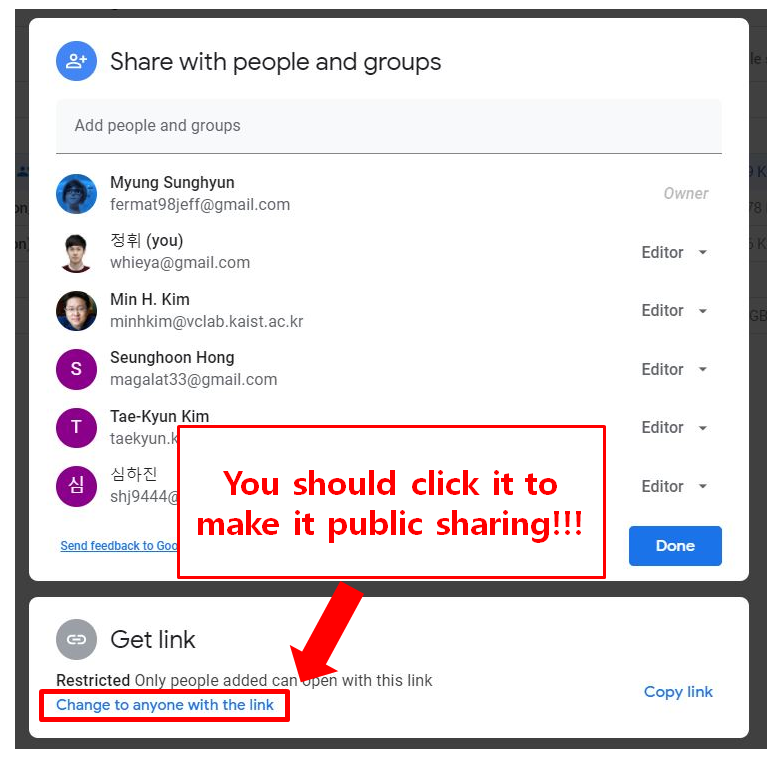



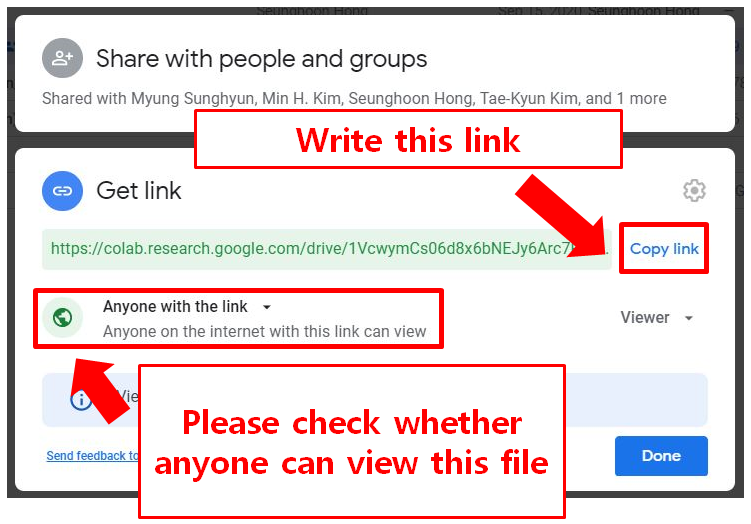